In [1]:
!pip3 install opencv-python
!pip3 install matplotlib

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import math

In [3]:
def fix_image_to_show(img):
    image = img.copy()
    image = image.astype('float32')
    max_pixel = np.max(image)
    min_pixel = np.min(image)
    if max_pixel == min_pixel:
        image[:, :, :] = 127
        image = image.astype('uint8')
        return image
    m = 255 / (max_pixel - min_pixel)
    image = image * m - min_pixel * m
    image = image.astype('uint8')
    return image

def show_image(img, name=None, cmap=None):
    image = img.copy()
    image = fix_image_to_show(image)
    plt.imshow(image, vmin=0, vmax=255, cmap=cmap)
    plt.show()
    if name is not None :
        plt.imsave(name + '.jpg', image, cmap=cmap)

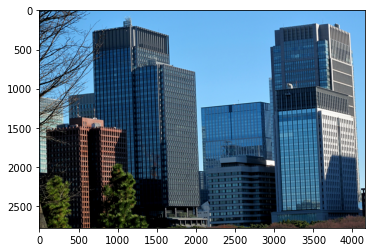

In [4]:
image = cv2.imread('resources/vns.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_image(image)
org_image = image.copy()

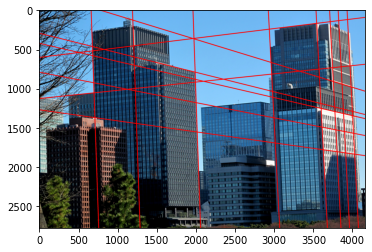

In [5]:
image = org_image.copy()
lines_image = image.copy()
image = cv2.GaussianBlur(image, (5, 5), 0)
gray_image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2GRAY)
kernel = np.ones((11, 11),np.uint8)
gray_image = cv2.morphologyEx(gray_image, cv2.MORPH_OPEN, kernel)
edges = cv2.Canny(gray_image, 100, 3 * 170)
hough_lines = cv2.HoughLines(edges, 1, np.pi/180, 110)
lines_theta = []
lines_points = []

ignore = []

for i in range(len(hough_lines)):
    ignore.append(False)

for i in range(len(hough_lines)):
    for j in range(i + 1, len(hough_lines)): 
        if i == j:
            continue 
        rho1, theta1 = hough_lines[i][0]
        rho2, theta2 = hough_lines[j][0]
        if abs(rho2 - rho1) < 100: 
            ignore[j] = True

ignore[83] = True
ignore[14] = True
ignore[35] = True


for i in range(len(hough_lines)):
    if ignore[i] == True:
        continue 
    line = hough_lines[i]
    rho, theta = line[0] 
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 10000*(-b)), int(y0 + 10000*(a)))
    pt2 = (int(x0 - 10000*(-b)), int(y0 - 10000*(a)))
    cv2.line(image, pt1, pt2, (255, 0, 0), 10)
    lines_points.append([pt1[0], pt1[1], pt2[0], pt2[1]])
    lines_theta.append([theta])
            
            
show_image(image)

In [6]:
lines_theta = np.asarray(lines_theta, dtype='float32')
lines_theta.reshape((lines_theta.shape[0], 1))
kmeans = KMeans(n_clusters=3, max_iter=300)
kmeans.fit(lines_theta)

KMeans(n_clusters=3)

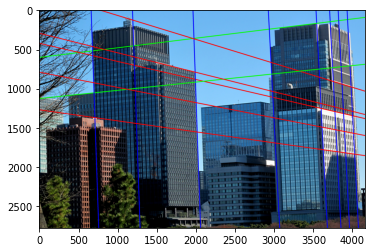

In [7]:
image = org_image.copy()
for i in range(len(lines_points)):
    x1, y1, x2, y2 = lines_points[i]
    theta = lines_theta[i, 0]
    color = (255, 0, 0)
    if 1.7 <= theta <= 2: 
        color = (255, 0, 0)
    elif 1 <= theta <= 1.5:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    pt1 = (x1, y1)
    pt2 = (x2, y2)
    cv2.line(image, pt1, pt2, color, 10)
show_image(image)

In [8]:
def find_intersection(lines):
    n = len(lines)
    A = np.zeros((n, 2))
    B = np.zeros((n, 1))
    for i in range(n):
        line = lines[i]
        x1, y1, x2, y2 = line
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        A[i, 1] = -m
        A[i, 0] = 1
        B[i] = b 
    pt = np.linalg.lstsq(A, B, rcond=None)[0]
    return np.asarray([math.floor(pt[1, 0]), math.floor(pt[0, 0]), 1], dtype='float32')
    

x_lines = []
y_lines = []
z_lines = []
255
for i in range(len(lines_points)): 
    x1, y1, x2, y2 = lines_points[i]
    theta = lines_theta[i, 0]
    if 1.7 <= theta <= 2: 
        x_lines.append([x1, y1, x2, y2])
    elif 1 <= theta <= 1.5:
        y_lines.append([x1, y1, x2, y2])
    else:
        z_lines.append([x1, y1, x2, y2])
        
    
vx = find_intersection(x_lines)
vy = find_intersection(y_lines)
vz = find_intersection(z_lines)

print(vx)
print(vy)
print(vz)
        

[9.138e+03 2.556e+03 1.000e+00]
[-2.9732e+04  4.2540e+03  1.0000e+00]
[-3.33600e+03 -1.32002e+05  1.00000e+00]


In [9]:
h = np.cross(vx, vy)
h /= (math.sqrt(h[0] * h[0] + h[1] * h[1]))
print(h)

[-4.3642454e-02 -9.9904722e-01  2.9523696e+03]


In [10]:
image = org_image.copy()
h_pt1 = (0, math.floor(-h[2] / h[1]))
h_pt2 = (math.floor(-h[2] / h[0]), 0)


In [11]:
image = org_image.copy()
image = cv2.resize(image, (0, 0), fx=1/20, fy=1/20)
vz_mm = vz / 20
vx_mm = vx / 20
vy_mm = vy / 20
vz_m = (math.floor(vz_mm[0]), math.floor(vz_mm[1]))
vy_m = (math.floor(vy_mm[0]), math.floor(vy_mm[1]))
vx_m = (math.floor(vx_mm[0]), math.floor(vx_mm[1]))




p :  1267.3016 2485.7466
f :  14507.641572633369


<ipython-input-12-9a0853eaf07a>:26: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(res3, (px, py), radius=10, thickness=30, color=(255, 0, 0))


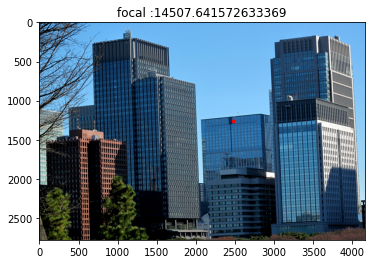

In [12]:
image = org_image.copy()
a1 = vx[0]
b1 = vx[1]
a2 = vy[0]
b2 = vy[1]
a3 = vz[0]
b3 = vz[1]
A = np.asarray([
    [a1 - a3, b1 - b3],
    [a2 - a3, b2 - b3]
], dtype='float32')

B = np.asarray([
    [a2 * (a1 - a3) + b2 * (b1 - b3)],
    [a1 * (a2 - a3) + b1 * (b2 - b3)]
], dtype='float32')

p = np.linalg.solve(A, B)
px = p[0, 0]
py = p[1, 0]
print("p : ", py, px)
f = -(px * px) - (py * py) + (a1 + a2) * px + (b1 + b2) * py - (a1 * a2 + b1 * b2)
f = math.sqrt(f)
print("f : ", f)
res3 = org_image.copy()
cv2.circle(res3, (px, py), radius=10, thickness=30, color=(255, 0, 0))
plt.imshow(res3)
plt.title("focal :" + str(f))
plt.savefig('res03.jpg')

In [13]:
cal_mat = np.asarray([
    [f, 0, px], 
    [0, f, py],
    [0, 0, 1]],
dtype='float32')

inv_cal = np.linalg.inv(cal_mat)

vx_inv = np.matmul(inv_cal, vx)
vy_inv = np.matmul(inv_cal, vy)
vz_inv = np.matmul(inv_cal, vz)

mh = (-h[0] / h[1])
zh = math.atan(mh)
print(zh * 180 / math.pi)

-2.5013229349600987


In [14]:
l = np.cross(vx_inv, vy_inv)

l /= np.linalg.norm(l)


l = np.dot(l, np.asarray(np.asarray([0, 1, 0], dtype='float32')))
l = math.acos(l)
print(180 - l * 180 / math.pi)

6.690084745534932
